In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
import seaborn as sns
import pymongo
from pymongo import MongoClient
from random import random
%matplotlib inline

In [28]:
client = MongoClient()
kiva = client.kiva

## Explore lender data

First let's check out the data

In [29]:
lenders = kiva.lenders
# how many records?
lenders.count()

1617189

Let's take a random sample of 500000 users

In [39]:
r = random()
cursor = lenders.find({'rnd': {'$gt': r}}).sort('rnd', pymongo.ASCENDING).limit(500000)
sample_lender = pd.DataFrame(list(cursor))
del sample_lender['_id']

In [40]:
sample_lender.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 15 columns):
country_code         215922 non-null object
image                500000 non-null object
invitee_count        500000 non-null int64
inviter_id           155129 non-null object
lender_id            500000 non-null object
loan_because         500000 non-null object
loan_count           500000 non-null int64
member_since         500000 non-null object
name                 499201 non-null object
occupation           500000 non-null object
occupational_info    500000 non-null object
personal_url         500000 non-null object
rnd                  500000 non-null float64
uid                  500000 non-null object
whereabouts          500000 non-null object
dtypes: float64(1), int64(2), object(12)
memory usage: 61.0+ MB


In [43]:
sample_lender.head(10)

,country_code,image,invitee_count,inviter_id,lender_id,loan_because,loan_count,member_since,name,occupation,occupational_info,personal_url,rnd,uid,whereabouts
0,ZA,"{u'id': 726677, u'template_id': 1}",0,None,mike10085837,,0,2010-06-22T12:16:27Z,Mike,,,,0.377334,mike10085837,Johannesburg
1,AU,"{u'id': 726677, u'template_id': 1}",0,None,shane5562,,0,2009-12-22T23:59:31Z,Shane,,,,0.377334,shane5562,Ocean Shores Victoria
2,US,"{u'id': 1029646, u'template_id': 1}",0,tom8659,diane2063,,1,2012-03-09T13:43:33Z,Diane,,,,0.377335,diane2063,Decatur GA
3,None,"{u'id': 726677, u'template_id': 1}",0,None,rachel3440,,0,2009-12-25T00:53:50Z,Rachel,student,,,0.377336,rachel3440,
4,None,"{u'id': 726677, u'template_id': 1}",0,None,carly4601,,0,2011-12-24T18:48:22Z,Carly,,,,0.377336,carly4601,
5,AU,"{u'id': 82628, u'template_id': 1}",0,asia10308244,emma2259,my contribution will empower other people.,38,2007-11-09T10:36:27Z,Emma,,,,0.377338,emma2259,Australian Capital Territory
6,US,"{u'id': 726677, u'template_id': 1}",0,None,david4819,,17,2008-05-02T02:36:01Z,David,Student,,,0.377338,david4819,Rochester MN
7,None,"{u'id': 726677, u'template_id': 1}",0,peter4822,kosh5369,,2,2009-11-27T22:47:05Z,Kosh,,,,0.377338,kosh5369,
8,US,"{u'id': 1503292, u'template_id': 1}",0,natashakhan,mangala7723,it's the best way to help someone get off thei...,37,2006-11-09T14:42:46Z,Mangala,Assistant Vice President,,,0.377339,mangala7723,Washington DC
9,US,"{u'id': 544394, u'template_id': 1}",0,vanessa7430,nancy2994,we are called to make a positive and lasting d...,2,2010-05-23T02:10:22Z,Nancy,Professor,College Professor,,0.377340,nancy2994,Florida


### Brief explanation of each column
`country_code` is a two-letter string representing the country filled by the registered user. E.g. `'US'` and `'HK'`.

`image` is a dictionary containing a picture id to obtain from a url and the template id specifying the size of the picture showing on pages: [Link](http://build.kiva.org/docs/data/media). This field could be useful if we want to do image classfication or create a feature for image size. But for now it's ok to drop it. 

`invitee_count` shows how many people the lender has invited to register on Kiva. `inviter_id` is a user's id if the lender was invited to the site and `None` otherwise. 

`lender_id` and `uid` are quite similar except for the case. Should explore more later.

`loan_because` is a text field for people writing the reason to give out loan on Kiva as a part of the profile. This could be useful if we want to classify lenders based on the cause. 

`loan_count` is the number of loans given out.

`member_since` is the timestamp for registration in the format of UTC.

`occupation` and `occupation_info` are filled by the lender.

`personal_url` is the personal online presense provided by the lender.

`whereabouts` is provided by the lender if she wants to show which city she comes from. 

Now we're going to clean some of them. 

In [44]:
# Select columns we care about for now
sample_lender = sample_lender[['country_code', 'invitee_count', 'loan_count', 'member_since', 'occupation', 'whereabouts']]

###Explore locations

In [45]:
print 'Number of missing values: ', sum(sample_lender['country_code'].isnull())
print 'Records we can infer the country from whereabouts:'
sample_lender[sample_lender['country_code'].isnull() & sample_lender['whereabouts']][['country_code','whereabouts']]

Number of missing values:  284078
Records we can infer the country from whereabouts:


,country_code,whereabouts
190,None,pittsburgh pa
273,None,Brooklyn NY
843,None,Redondo Beach CA
1169,None,Grovedale Victoria
1189,None,North Andover MA
1402,None,Earth 銀河系
1504,None,Slough Berks
1620,None,Vancouver BC
1713,None,Chicago
2134,None,London


We certainly can infer the country from whereabouts but it's hard to do it since it requires some manual work. So for the EDA phase we can just drop them. 

In [46]:
# Drop missing country_code
sample_lender = sample_lender[~sample_lender['country_code'].isnull()]

### Where are people from?

In [47]:
# list of countries
sample_lender['country_code'].unique()

array([u'ZA', u'AU', u'US', u'CA', u'SE', u'GB', u'IN', u'DE', u'KW',
       u'NZ', u'IT', u'JP', u'PH', u'BE', u'NO', u'CR', u'DK', u'FR',
       u'ID', u'RO', u'SG', u'FI', u'MM', u'KR', u'TW', u'PT', u'PK',
       u'CH', u'IS', u'EG', u'MY', u'NL', u'SC', u'BR', u'MX', u'SI',
       u'SK', u'TH', u'ES', u'TR', u'DZ', u'BW', u'UY', u'PL', u'PA',
       u'LT', u'AE', u'AT', u'IE', u'MD', u'CZ', u'RU', u'CO', u'IL',
       u'UG', u'VN', u'SA', u'BG', u'CN', u'UA', u'KE', u'KH', u'LU',
       u'HR', u'ML', u'GE', u'GT', u'TG', u'GH', u'IR', u'AR', u'HK',
       u'PR', u'PE', u'QA', u'AF', u'ET', u'NG', u'TZ', u'DO', u'UM',
       u'CL', u'BO', u'SV', u'LK', u'GR', u'EE', u'PS', u'AN', u'LA',
       u'HU', u'IQ', u'FO', u'MC', u'NA', u'EC', u'BD', u'HT', u'MN',
       u'BB', u'CK', u'LB', u'WS', u'LI', u'AM', u'AQ', u'GY', u'GM',
       u'ZM', u'ZW', u'YE', u'SN', u'CI', u'UZ', u'GP', u'LV', u'RS',
       u'JO', u'AI', u'RW', u'TN', u'KN', u'HN', u'SY', u'MA', u'AL',
       u'OM', u'CY',

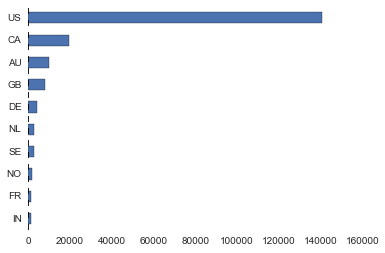

In [48]:
# Create the bar chart for country_code
country_cnt = sample_lender['country_code'].value_counts()
country_cnt.iloc[:10].plot(kind='barh').invert_yaxis()

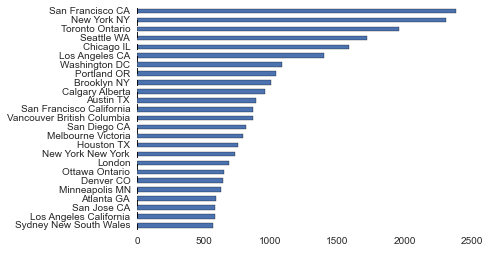

In [49]:
# Create bar chart for whereabouts to compare with countries
whereabout_cnt = sample_lender[sample_lender['whereabouts']!='']['whereabouts'].value_counts()
whereabout_cnt.iloc[:25].plot(kind='barh').invert_yaxis()

Most lenders come from US, as expected. Country code list: [wiki](http://en.wikipedia.org/wiki/ISO_3166-1_alpha-2). 

Among those people who have filled the field, the first one is Toronto instead of San Francisco. The followings are some major cities like Seattle and New York. London actually has more people than Brooklyn.

###Explore member_since

In [50]:
# Transform the format to datetime first
sample_lender['member_since'] = sample_lender['member_since'].map(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))

print 'Latest date: ', sample_lender['member_since'].max()
print 'Earliest date: ', sample_lender['member_since'].min()

Latest date:  2015-02-18 17:32:29
Earliest date:  2006-01-01 09:01:01


###Explore loan count

0     39706
1     36379
2     14310
3     11536
4     10427
5      8760
6      7626
7      6602
8      5769
9      4672
10     4071
11     3638
12     3199
13     2913
14     2724
15     2366
16     2357
17     2093
18     1901
19     1834
dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x183bba7d0>]], dtype=object)

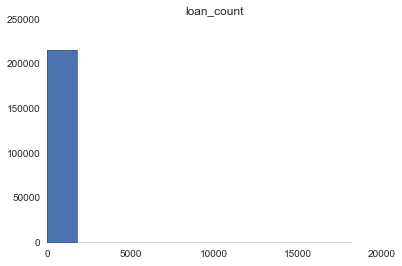

In [58]:
# how's the distribution of loan count
# loan_count_cnt = sample_lender[sample_lender['loan_count']!='']['loan_count'].value_counts()
# loan_count_cnt.iloc[:25].plot(kind='barh').invert_yaxis()
print sample_lender['loan_count'].value_counts().iloc[:20]
sample_lender.hist('loan_count')

This one shows an extremely long tail. The top 4 lenders make over 10000 loans and most people make way less than that. 

###Explore invitee count
This may be a signal about how loyalty a user is

0     168164
1      27809
2       9640
3       4428
4       2110
5       1205
6        775
7        481
8        304
9        213
10       165
11       109
12        91
14        55
15        53
13        51
16        34
18        23
17        22
20        17
dtype: int64


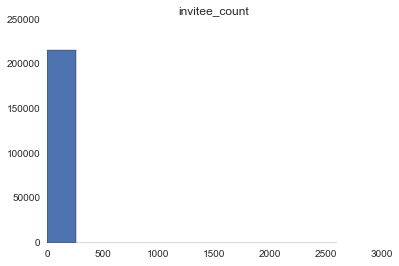

In [66]:
sample_lender.hist('invitee_count')
print sample_lender['invitee_count'].value_counts().iloc[:20]

This one also shows a long tail and most people invited only a handful of people. 

###Explore occupation

Missing values:  116979
Percentage of students:  0.035206


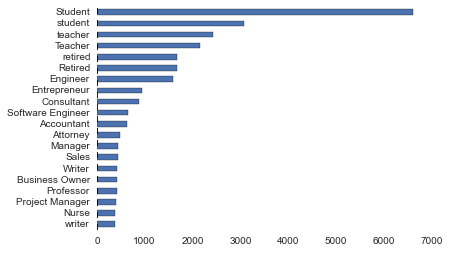

In [87]:
print 'Missing values: ', sum(sample_lender['occupation']=='')
# For those who filled the blank
occupation_cnt = sample_lender[sample_lender['occupation']!='']['occupation'].value_counts()
# What's the top 20 titles?
occupation_cnt.iloc[:20].plot(kind='barh').invert_yaxis()
mask = (sample_lender['occupation']=='Student') | (sample_lender['occupation']=='student') |\
        (sample_lender['occupation']=='Teacher') | (sample_lender['occupation']=='teacher') |\
        (sample_lender['occupation']=='retired') | (sample_lender['occupation']=='Retired')
print 'Percentage of students: ', sample_lender[mask]['occupation'].count() / 500000.

Students, teachers, and retired people seem like the majority of lenders with 3.5%. But this result is discounted because people can fill whatever title they want. 

###How do country and loan count relate?

In [108]:
mean_loan_country = sample_lender.groupby('country_code')['loan_count'].mean().order(ascending=False)
mean_loan_country.iloc[:20]

country_code
DM              2270.666667
WF               301.000000
MO               141.750000
GI               120.333333
KN               119.000000
ST                93.000000
KZ                92.600000
KW                91.129032
MC                82.500000
CK                69.000000
TH                68.725146
CH                60.075639
AQ                58.500000
GD                52.500000
NL                46.168320
NF                46.000000
NC                45.571429
VC                42.500000
AT                42.208054
LI                40.000000
Name: loan_count, dtype: float64

The top records are from several small countries mainly due to the small amount of users.

###How do city/region and loan count relate?

In [109]:
mean_loan_city = sample_lender.groupby('whereabouts')['loan_count'].mean().order(ascending=False)
mean_loan_city.iloc[:20]

whereabouts
Sea Mills Bristol                         18189.0
Wimbledon Kent                            12221.0
Hoodsport WA                               7745.0
Phuket                                     6880.0
Ruinerwold                                 6764.0
Bellinzona                                 6671.0
Dry Run PA                                 6529.0
Koeln NRW                                  6440.0
Exeter Tasmania                            5000.0
Goonellabah NSW                            4866.0
Tokyo Shibuya-ku                           4756.0
http://KivaFriends.org s hertogenbosch     4499.0
DIJON                                      4147.0
http://KivaFriends.org Alexandria VA       3421.0
Sth Queensferry                            2944.0
Northern California                        2937.5
Veberod                                    2895.0
Greensborough Vic                          2767.0
港区 東京都                                     2754.0
Niagara Falls,  Ontario               

###How do invitee count and loan count relate?

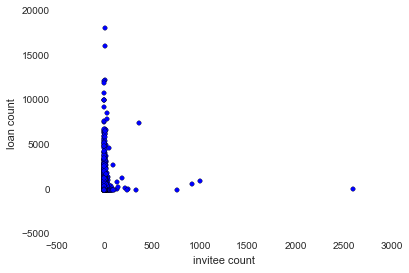

In [119]:
plt.scatter(sample_lender['invitee_count'], sample_lender['loan_count'])
plt.xlabel('invitee count')
plt.ylabel('loan count')

There's no clear relationship between invitee count and loan count. 

## Explore loans data

In [41]:
loans = kiva.loans
# how many records?
loans.count()

841160

In [151]:
r = random()
cursor_loan = loans.find({'rnd': {'$lt': 0.095}}).sort('rnd', pymongo.ASCENDING).limit(80000)
sample_loans = pd.DataFrame(list(cursor_loan))
del sample_loans['_id']

In [152]:
sample_loans.head(5)

,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,delinquent,description,funded_amount,funded_date,id,...,posted_date,rnd,sector,status,tags,terms,themes,translator,use,video
0,Personal Purchases,NaN,True,"[{u'gender': u'M', u'first_name': u'Samvel ', ...",NaN,None,"{u'languages': [u'en'], u'texts': {u'en': u'Sa...",1000,2014-02-25T00:42:52Z,651758,...,2013-12-27T16:40:12Z,0.000002,Personal Use,paid,"[{u'name': u'user_favorite'}, {u'name': u'#Par...","{u'disbursal_date': u'2013-12-12T08:00:00Z', u...",None,"{u'image': 1210811, u'byline': u'Eric Saltmarsh'}","to organize a nice party for his son, who is g...",None
1,Farming,NaN,True,"[{u'gender': u'F', u'first_name': u'Shiella', ...",NaN,None,"{u'languages': [u'en'], u'texts': {u'en': u'Sh...",425,2011-04-15T09:49:47Z,289727,...,2011-04-12T14:50:03Z,0.000002,Agriculture,paid,[],"{u'disbursal_date': u'2011-03-12T08:00:00Z', u...",None,"{u'image': 402980, u'byline': u'Marsha Berkowi...",To purchase services to increase crop yield,None
2,Food Market,NaN,True,"[{u'gender': u'M', u'first_name': u'Hakim', u'...",NaN,None,"{u'languages': [u'en'], u'texts': {u'en': u'Ha...",875,2010-12-19T22:33:58Z,255891,...,2010-12-08T18:20:12Z,0.000002,Food,paid,[],"{u'disbursal_date': u'2010-12-11T08:00:00Z', u...",None,"{u'image': 88345, u'byline': u'teresa kramer'}",sugar and beans,None
3,Taxi,NaN,True,"[{u'gender': u'M', u'first_name': u'Omar', u'l...",NaN,None,"{u'languages': [u'en'], u'texts': {u'en': u'Om...",900,2012-01-27T02:15:03Z,366606,...,2011-12-04T16:00:05Z,0.000003,Transportation,paid,[],"{u'disbursal_date': u'2011-11-18T08:00:00Z', u...",None,"{u'image': 985313, u'byline': u'kathleen melym...","to purchase a tuk tuk, a three-wheeled motorcy...",None
4,Recycled Materials,NaN,False,"[{u'gender': u'F', u'first_name': u'Julieta', ...",NaN,None,"{u'languages': [u'en'], u'texts': {u'en': u'Ju...",250,2012-05-04T05:58:17Z,419475,...,2012-05-01T07:02:40Z,0.000005,Retail,paid,[],"{u'disbursal_date': u'2012-04-10T07:00:00Z', u...",None,"{u'image': 456803, u'byline': u'Susan Grantham'}",to buy stocks of tires to make flower pots.,None


In [153]:
sample_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79859 entries, 0 to 79858
Data columns (total 31 columns):
activity                         79859 non-null object
basket_amount                    452 non-null float64
bonus_credit_eligibility         79859 non-null bool
borrowers                        79859 non-null object
currency_exchange_loss_amount    3328 non-null float64
delinquent                       3587 non-null object
description                      79859 non-null object
funded_amount                    79859 non-null int64
funded_date                      75724 non-null object
id                               79859 non-null int64
image                            79859 non-null object
journal_totals                   79859 non-null object
lender_count                     79859 non-null int64
loan_amount                      79859 non-null int64
location                         79859 non-null object
name                             79859 non-null object
paid_amount        

###Explore activity

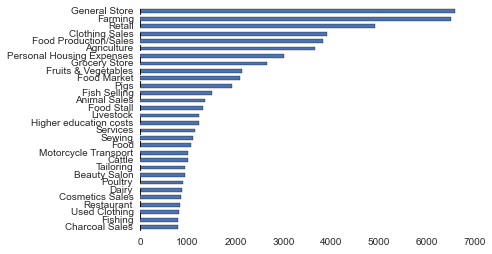

In [120]:
activity_cnt = sample_loans['activity'].value_counts()
activity_cnt.iloc[:30].plot(kind='barh').invert_yaxis()

The types of activities have overlap. For example, fruits & vegetables could be argued under farming. There's no clear description for each activity on Kiva's website. 

###Explore description

In [121]:
sample_loans['description'].iloc[10]

{u'languages': [u'en'],
 u'texts': {u'en': u"Moses O. is single and lives in  a rental house that has electricity and piped water. He has operated a caf\xe9 for the past year; his customers are neighbors and passersby.  Moses is requesting a loan for 10,000 KES, which he will use to purchase maize flour, sugar and cooking oil. His greatest monthly expenses are rent and electricity bills. Moses dreams of being self-reliant and satisfying his customers' needs in the future. He decided to join Yehu to access loans to increase his business.\r\n"}}

+++++++++++++++

####Note

Above is a sample description of the loan story. If the language is not in English, the text will be in both original language and English. The story may be a good source to extract latent features of the story and people behind it instead of simply categorizing it according to its usage. This might lead to a better understanding of the needing level of this loan and also to the understanding of the common traits a perticular lender is more likely looking for after linking the feature matrix to lender profiles.

++++++++++++++++

###Explore location

In [154]:
loan_location = sample_loans['location'].iloc[10]
loan_location

{u'country': u'Mongolia',
 u'country_code': u'MN',
 u'geo': {u'level': u'town',
  u'pairs': u'47.916667 106.916667',
  u'type': u'point'},
 u'town': u'Ulaanbaatar'}

The location gives out much information. It follows [GeoRSS Model](http://www.georss.org/model.html) and can possibly pinpoint the location to the level of town. 

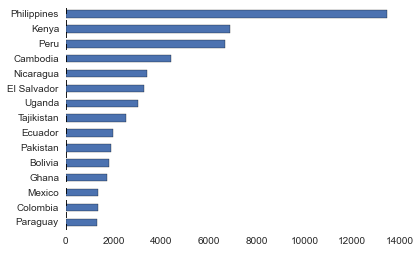

In [155]:
# create a data frame with all locations and do sth on it
loan_countries = sample_loans['location'].map(lambda x: x['country'])
loan_countries.value_counts().iloc[:15].plot(kind='barh').invert_yaxis()

###Explore bonus_credit_eligibility
Sometimes Kiva will have some loans with bonus, which benefits lenders by decrease the actual amount lending out.

In [156]:
sample_loans['bonus_credit_eligibility'].value_counts()

True     46437
False    33422
dtype: int64

###Explore lender count

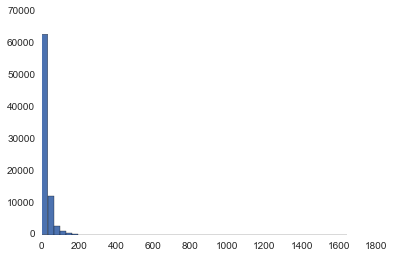

In [170]:
# sample_loans['lender_count'].value_counts().iloc[:20].plot(kind='barh').invert_yaxis()
sample_loans['lender_count'].hist(bins=50)

###Explore funded amount

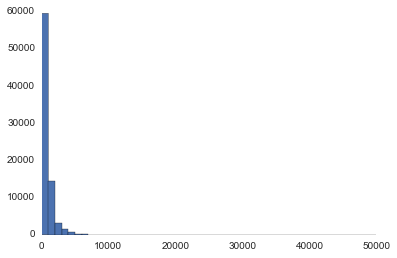

In [157]:
sample_loans['funded_amount'].hist(bins=50)

###Explore sector

In [159]:
sample_loans['sector'].value_counts()

Food              19965
Agriculture       17719
Retail            17532
Services           5873
Clothing           5101
Housing            3199
Transportation     2511
Education          1765
Arts               1496
Personal Use       1359
Construction       1272
Manufacturing      1121
Health              650
Wholesale           148
Entertainment       148
dtype: int64

Sector is a general categorization of loans.

###Explore status

In [160]:
sample_loans['status'].value_counts()

paid                60257
in_repayment        13283
expired              2009
defaulted            1744
inactive_expired     1073
refunded              486
fundraising           452
deleted               298
inactive              181
funded                 42
issue                  31
reviewed                3
dtype: int64

The proportion of loans paid in full is very high. If we define 'paid' and 'funded' as success, and 'expired', 'defaulted', 'inactive_expired', and 'refunded' as failure, then the ratio would be:

In [162]:
(60257.+42.) / (2009+1744+1073+486)

11.351468373493976

... which means there's one out of twelve loans cannot get funded or has the risk of default. Besides, among those loans, there are over *3000* loans didn't get funded. **What're some possible reasons? Are they too risky? Do lenders have biases? How can we help them get funded?**

## Explore loan and lender

In [42]:
loans_lenders = kiva.loans_lenders
# how many records?
loans_lenders.count()

544679

In [163]:
r = random()
cursor_loans_lenders = loans_lenders.find({'rnd': {'$lt': 0.2}}).sort('rnd', pymongo.ASCENDING).limit(100000)
sample_loans_lenders = pd.DataFrame(list(cursor_loans_lenders))
del sample_loans_lenders['_id']

In [165]:
sample_loans_lenders.head(10)

,id,lender_ids,rnd
0,780584,"[keith7047, francis9061, navneet1072, peter211...",0.000001
1,640429,"[ccmclane, phil2916, delona, andy9980, cam6714...",0.000002
2,311033,"[rolfpirjo5655, bill1069, matt9599, eugene]",0.000003
3,712481,"[paul2268, lars5716, karin9360, andre6084]",0.000004
4,794188,"[martin1969, jouko1940, julian8731, julia3841,...",0.000006
5,583313,"[fbadslab, wongacom3393, lindsay5252]",0.000006
6,531239,[hungryhamper6067],0.000009
7,377780,"[laura4359, marla7745, holly6980]",0.000012
8,718438,"[ellen11009580, elias7700, peggy2680, pranav50...",0.000012
9,446847,"[steve2304, julie46192691, eunice8584, lorenza...",0.000014


In [166]:
sample_loans_lenders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 3 columns):
id            100000 non-null int64
lender_ids    99502 non-null object
rnd           100000 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.1+ MB


The null values mean that certain loans haven't received any funds. 